**Методы классификации недостоверных новостных сообщений.**

*Силина Полина*

**XGBoost с предобработкой текстов алгоритмом лемматизации RusVectores.**

##0. Подключение к диску

In [1]:
# Connectable to disk
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##1. Чтение данных из файла

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Выбираем этап 2, где тексты не предобработаны алгоритмом лемматизации
data = pd.read_csv('gdrive/My Drive/NewsProject/Data/PreparedData/PreparedData_Version_00/step2.csv', sep=";", header=[0], encoding='Cp1251')
data.rename(columns={"Unnamed: 5" : "IsBroken"}, inplace=True)# На случай, если какие-то данные повредились

need_to_del = ['интерфакс', 'панорам']
for word in need_to_del:
      data['Text'] = data['Text'].str.replace(word, "")
data.head()

,Site,Heading,Text,Value,Type,IsBroken
0,https://www.interfax.ru/business/683812,Данные о 5 тысячах вкладчиков ВТБ утекли в инт...,в интернете появилась информация о продаже дан...,True,Business,NaN
1,https://www.interfax.ru/business/683806,Рубль вечером чуть сократил темпы снижения к д...,доллар и евро немного укрепляются на московско...,True,Business,NaN
2,https://www.interfax.ru/business/683807,Alibaba установила рекорд продаж в День холост...,китайская компания установила новый рекорд...,True,Business,NaN
3,https://www.interfax.ru/business/683805,Рынок акций начал неделю со снижения на опасен...,рынок акций рф начал неделю со снижения вслед ...,True,Business,NaN
4,https://www.interfax.ru/business/683768,Венесуэла начала продавать нефть по сниженным ...,венесуэла вынуждена продавать нефть по сниженн...,True,Business,NaN


## 2. Подготовка токенизатора

In [4]:
class Tokenizer:
    def __init__(self, w2v_model, pipeline):
        self.w2v_model = w2v_model
        self.pipeline = pipeline
    
    def tokenize(self, text):
        # Эта функция взята отсюда:
        # https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb
        
        processed = self.pipeline.process(text) 
        output = [l for l in processed.split('\n') if not l.startswith('#')]
        tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in output if w]
        tagged_propn = []
        propn  = []
        for t in tagged:
            if t.endswith('PROPN'):
                if propn:
                    propn.append(t)
                else:
                    propn = [t]
            else:
                if len(propn) > 1:
                    name = '::'.join([x.split('_')[0] for x in propn]) + '_PROPN'
                    tagged_propn.append(name)
                elif len(propn) == 1:
                    tagged_propn.append(propn[0])
                tagged_propn.append(t)
                propn = []
        return [self.w2v_model.vocab[w].index for w in tagged_propn if w in self.w2v_model.vocab]

In [5]:
!pip install ufal.udpipe

     |████████████████████████████████| 307kB 4.5MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626558 sha256=5e22ce2229c845a9b8b3cbcee101c831d285efa6fc783064b2f524f8405144a4
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [6]:
from ufal.udpipe import Model, Pipeline
import gensim

model = Model.load('gdrive/My Drive/NewsProject/Tokenizer/udpipe_syntagrus.model') 
pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('gdrive/My Drive/NewsProject/Tokenizer/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz', binary=False)


In [7]:
tokenizer = Tokenizer(w2v_model, pipeline)

##3. Подготовка данных

In [8]:
from tqdm import tqdm_notebook
import pickle

In [9]:
tokenized_texts = []
for i in range(len(data["Text"])):
  try:
    print(i)
    tokenized_texts.append(tokenizer.tokenize(data["Text"][i]))
    data["IsBroken"][i] = 0
  except TypeError:
      print("Broken")
      data["IsBroken"][i] = 1
      pass

0
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
Broken
3517
3518
Broken
3519
3520
3521
Broken
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
Broken
3535
3536
3537
3538
3539
Broken
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
Broken
3597
3598
3599
3600
3601
3602
3603
Broken
3604
Broken
3605
3606
3607
Broken
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
36

In [10]:
data_prepared = data.drop(np.where(data["IsBroken"] == 1)[0])
data_prepared["Tokens"] = tokenized_texts
del data_prepared["IsBroken"]
data_prepared['Value'].replace([False,True],[0,1],inplace=True) 
data_prepared.head()

,Site,Heading,Text,Value,Type,Tokens
0,https://www.interfax.ru/business/683812,Данные о 5 тысячах вкладчиков ВТБ утекли в инт...,в интернете появилась информация о продаже дан...,1,Business,"[2705, 174, 487, 1365, 5729, 156, 22608, 92584..."
1,https://www.interfax.ru/business/683806,Рубль вечером чуть сократил темпы снижения к д...,доллар и евро немного укрепляются на московско...,1,Business,"[968, 3852, 1129, 12513, 137, 5408, 6241, 521,..."
2,https://www.interfax.ru/business/683807,Alibaba установила рекорд продаж в День холост...,китайская компания установила новый рекорд...,1,Business,"[995, 144, 252, 14, 2170, 1365, 28, 3138, 5, 2..."
3,https://www.interfax.ru/business/683805,Рынок акций начал неделю со снижения на опасен...,рынок акций рф начал неделю со снижения вслед ...,1,Business,"[864, 1702, 1529, 46, 639, 2602, 2403, 281, 15..."
4,https://www.interfax.ru/business/683768,Венесуэла начала продавать нефть по сниженным ...,венесуэла вынуждена продавать нефть по сниженн...,1,Business,"[1761, 1120, 2532, 33827, 1146, 7361, 7056, 34..."


## 4. Изучение данных

In [11]:
data_prepared.groupby("Type").count()

,Site,Heading,Text,Value,Tokens
Type,,,,,
Books,5,5,5,5,5
Business,394,394,394,394,394
Culture,67,67,67,67,67
Economics,125,125,125,125,125
Politics,700,700,700,700,700
Russia,1356,1356,1356,1356,1356
Science,138,138,138,138,138
Society,1727,1727,1727,1727,1727
World,1064,1064,1064,1064,1064


In [12]:
data_prepared.groupby("Value").count()

,Site,Heading,Text,Type,Tokens
Value,,,,,
0,2695,2695,2695,2695,2695
1,2881,2881,2881,2881,2881


In [13]:
all_words = [word for tokens in data_prepared["Tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data_prepared["Tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s слов, размер словаря - %s" % (len(all_words), len(VOCAB)))
print("Максимальная длина текста - %s" % max(sentence_lengths))

700926 слов, размер словаря - 32125
Максимальная длина текста - 1784


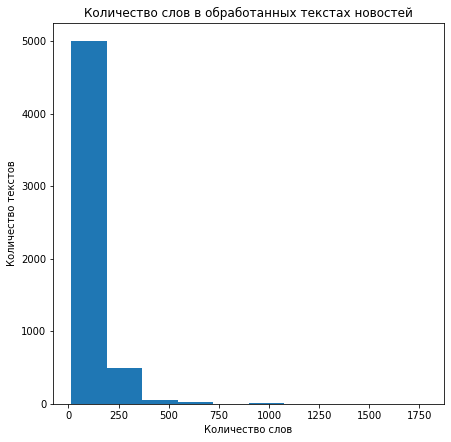

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7)) 
plt.xlabel('Количество слов')
plt.ylabel('Количество текстов')
plt.title('Количество слов в обработанных текстах новостей')
plt.hist(sentence_lengths)
plt.show()

##5. Подготовка векторного представления слов

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
  count_vectorizer = CountVectorizer()
  emb = count_vectorizer.fit_transform(data)
  return emb, count_vectorizer

list_corpus = data_prepared["Text"].tolist()
list_labels = data_prepared["Value"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

##6. Визуализация векторных представлений

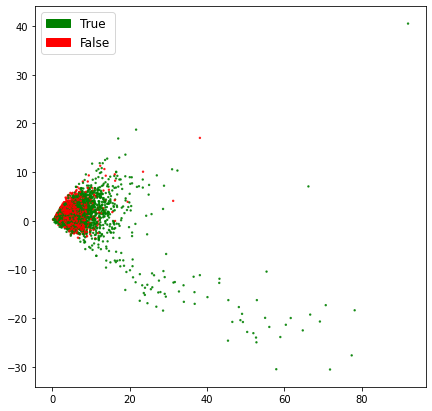

In [17]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
  lsa = TruncatedSVD(n_components=2)
  lsa.fit(test_data)
  lsa_scores = lsa.transform(test_data)
  
  color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
  color_column = [color_mapper[label] for label in test_labels]
  colors = ['red','green']
  if plot:
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    green_patch = mpatches.Patch(color='green', label='True')
    red_patch = mpatches.Patch(color='red', label='False')
    plt.legend(handles=[green_patch, red_patch], prop={'size': 12})

fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train_counts, y_train)
plt.savefig('RusVectores.png')
plt.show()

## 7. XGBClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
param_test = {
    'max_depth':range(3),
    'min_child_weight':range(2, 10, 2),
    'n_estimators': range(100, 700, 50)
}
gsearch = GridSearchCV(estimator = XGBClassifier(), 
param_grid = param_test, n_jobs=-1, cv=5)

In [ ]:
gsearch.fit(X_train_counts, y_train)
gsearch.best_params_

In [ ]:
xgb = XGBClassifier(max_depth=2, min_child_weight=2, n_estimators=650)
xgb.fit(X_train_counts, y_train)

y_predicted_counts = xgb.predict(X_test_counts)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives + false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives / total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.961, precision = 0.962, recall = 0.961, f1 = 0.961


##8. Исследование результата

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, fontsize=20)
  plt.yticks(tick_marks, classes, fontsize=20)
    
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
  plt.tight_layout()
  plt.ylabel('True label', fontsize=30)
  plt.xlabel('Predicted label', fontsize=30)

  return plt

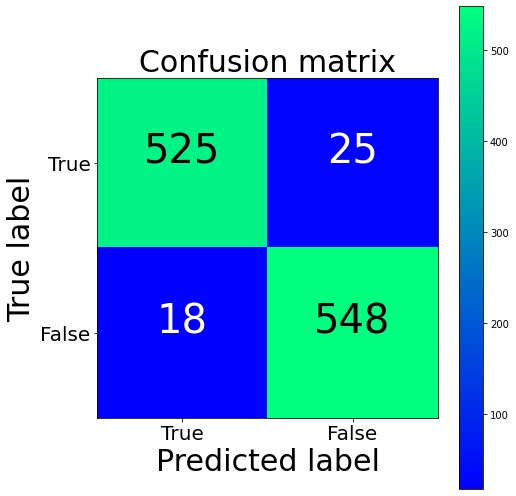

[[525  25]
 [ 18 548]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts, labels=[1, 0])
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=["True", "False"], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## 9. Сохранение первой модели

In [ ]:
# Обучаем на всем наборе данных

X_counts, count_vectorizer = cv(list_corpus)
X_test_counts = count_vectorizer.transform(X_test)

xgb = XGBClassifier(max_depth=2, min_child_weight=2, n_estimators=650)
xgb.fit(X_counts, list_labels)

y_predicted_counts = xgb.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.987, precision = 0.988, recall = 0.987, f1 = 0.987


In [ ]:
import joblib
with open('gdrive/My Drive/NewsProject/Модели 2021/Файлы моделей/XGBoost (RusVectores)/Vectorize_XGBClassifier_RusVectores.pkl', 'wb') as f:
  joblib.dump(count_vectorizer, f) 

In [ ]:
import pickle
with open('gdrive/My Drive/NewsProject/Модели 2021/Файлы моделей/XGBoost (RusVectores)/XGBClassifier_RusVectores.pickle', 'wb') as f:
  pickle.dump(xgb, f)

## 10. TFIDF

In [18]:
def tfidf(data):
  tfidf_vectorizer = TfidfVectorizer()
  train = tfidf_vectorizer.fit_transform(data)

  return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

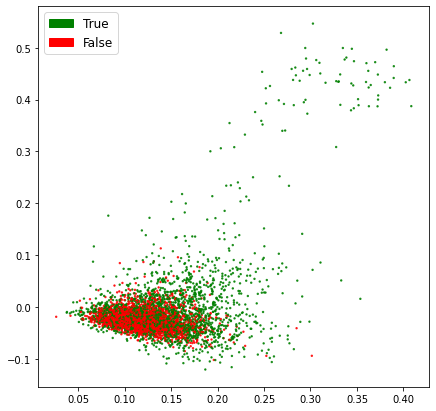

In [19]:
fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train_tfidf, y_train)
plt.savefig('RusVectores и TF-IDF.png')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
param_test = {
    'max_depth':range(3),
    'min_child_weight':range(2, 10, 2),
    'n_estimators': range(100, 700, 50)
}

gsearch_tfidf = GridSearchCV(estimator = XGBClassifier(), 
param_grid = param_test, n_jobs=-1, cv=5)

In [ ]:
gsearch_tfidf.fit(X_train_tfidf, y_train)
gsearch_tfidf.best_params_

{'criterion': 'entropy'}

In [ ]:
xgb_tfidf = XGBClassifier(max_depth=2, min_child_weight=2, n_estimators=650)
xgb_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = xgb_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.965, precision = 0.965, recall = 0.965, f1 = 0.965


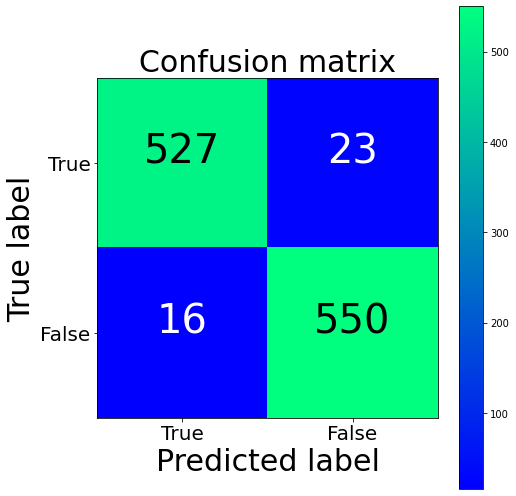

TFIDF confusion matrix
[[527  23]
 [ 16 550]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf, labels=[1, 0])
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm2, classes=['True','False'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)

## 11. Сохранение второй модели

In [ ]:
# Обучаем на всем наборе данных

X_counts_tfidf, tfidf_vectorizer = tfidf(list_corpus)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

xgb_tfidf = XGBClassifier()
xgb_tfidf.fit(X_counts_tfidf, list_labels)

y_predicted_counts = xgb_tfidf.predict(X_test_tfidf)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.955, precision = 0.956, recall = 0.955, f1 = 0.955


In [ ]:
import pickle
with open('gdrive/My Drive/NewsProject/Модели 2021/Файлы моделей/XGBoost (RusVectores, TF-IDF)/XGBClassifier_RusVectores_TFIDF.pickle', 'wb') as f:
  pickle.dump(xgb_tfidf, f)

In [ ]:
import joblib
with open('gdrive/My Drive/NewsProject/Модели 2021/Файлы моделей/XGBoost (RusVectores, TF-IDF)/Vectorize_XGBClassifier_RusVectores_TFIDF.pkl', 'wb') as f:
  joblib.dump(tfidf_vectorizer, f)